# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


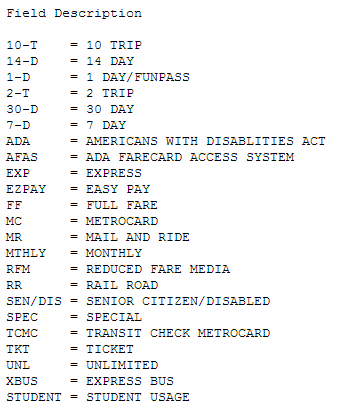

In [9]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os
import statistics

from sklearn import svm, datasets, ensemble
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [2]:
MTA = np.load("MTA_Fare.npy")

In [3]:
MTA

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [4]:
MTA = MTA.astype('float')
MTA[MTA==-1]=np.nan
MTA

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [5]:
print ("MTA array shape:", MTA.shape)
print ("MTA array shape summed over all ride types:", np.nansum(MTA,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [30]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

In [31]:
MTA[599][22]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

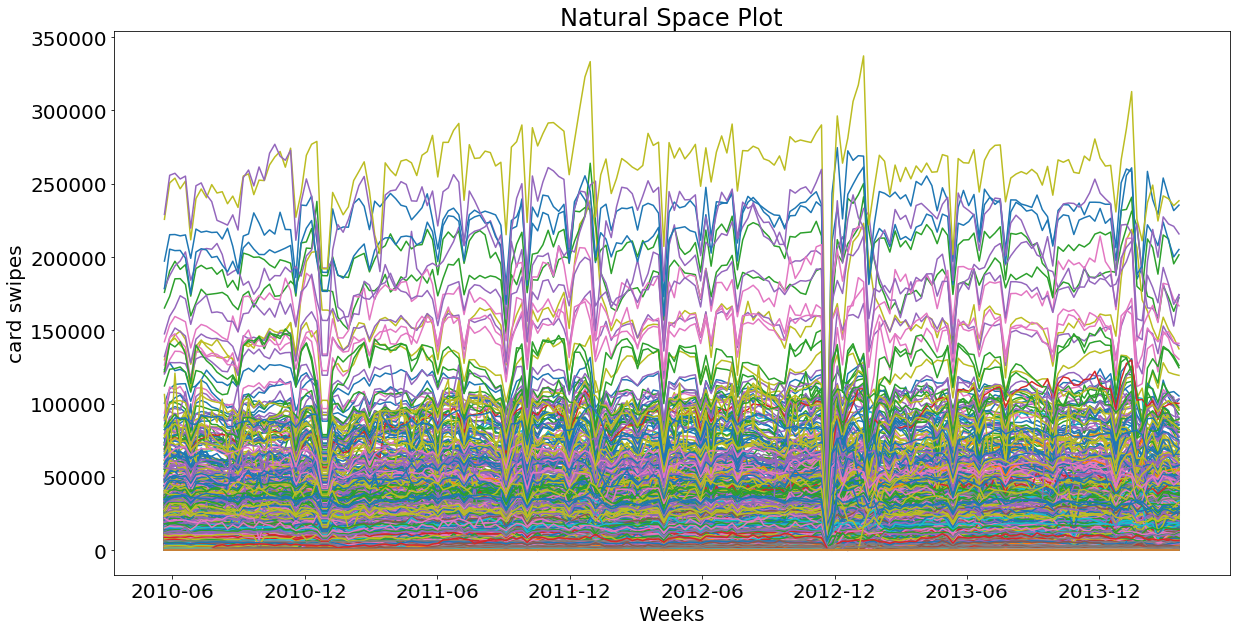

In [178]:
pl.figure(figsize=(20,10))
date = pd.date_range("2010-05-21","2014-03-21",194)
for i in range(0,599):
    for j in range(0,22):
        pl.plot(date,MTA[i][j])
pl.xlabel('Weeks')
pl.ylabel('card swipes')
pl.title("Natural Space Plot")

Figure 1: time series between weeks and card swipes of all ridetypes and stations in natural space. 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


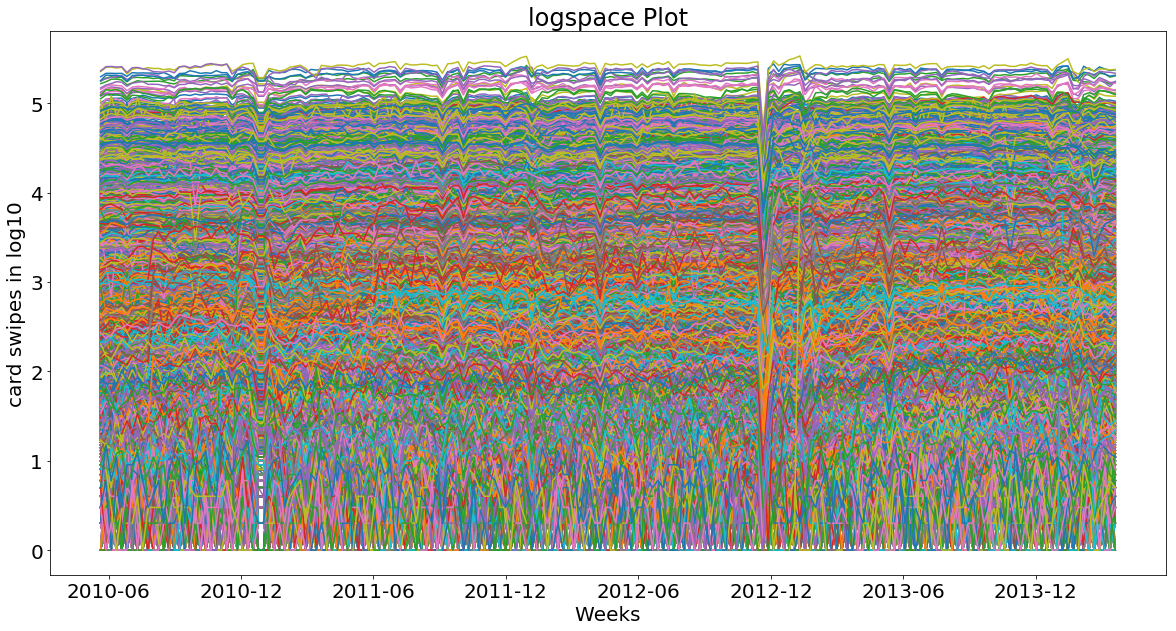

In [179]:
pl.figure(figsize=(20,10))
date = pd.date_range("2010-05-21","2014-03-21",194)
for i in range(0,599):
    for j in range(0,22):
        pl.plot(date,np.log10(MTA[i][j]))
pl.xlabel('Weeks')
pl.ylabel('card swipes in log10')
pl.title("logspace Plot")

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



The significant drop in all time series judging from the log space and natural space graphs seems to be centered around a week in November of 2012, seemingly dropping all to zero, and seem to return back to normal when it reached December. Because of the regular pattern it continued after December, I want to assume that all records had recorded that week as zero across ride types and stations, possibly due to missing information. Hurricane Sandy was around from end of October to beginning of November, and so the affects of the disaster might have impacted transit.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [6]:
#for i in range(0,22):
#    print(np.nanstd(MTA[::][i]))

In [7]:
MTAc = np.nansum(MTA,axis=0)

In [8]:
#MTAc = pd.rolling_mean(MTAc,1)

In [9]:

def change(x):
    MTAchange = []
    for i in range(0,193):
        change = abs((MTAc[x][i+1] - MTAc[x][i]) / MTAc[x][i])
        MTAchange.append(change)
    print(str(ridetype[x]))
    print('stdev ' + str(np.nanstd(MTAc[::][x])))
    print('fractional change over time ' + str((MTAc[x][1] - MTAc[x][0]) / MTAc[x][0] - (MTAc[x][-1] - MTAc[x][-2]) / MTAc[x][-2] ))

    
    pl.figure(figsize=(10,5))
    ylim(top=2)
    date = range(193)
    pl.plot(date,MTAchange)
    pl.xlabel('Weeks')
    pl.ylabel('Fractional change')
    pl.title(str(ridetype[x]) + " Plot")
    pl.show()

10t
stdev 1212509.30371
fractional change over time 0.0930669213371


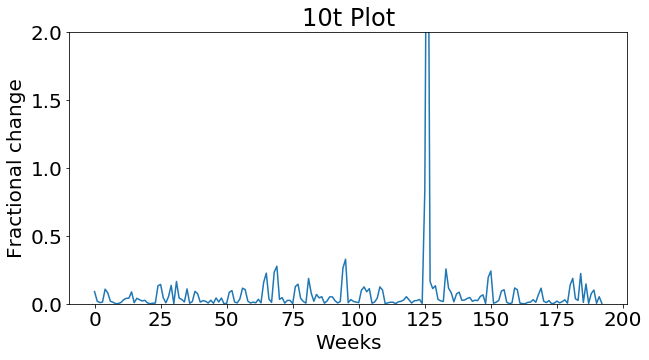

In [170]:
change(0)

In [10]:
MTAc = np.nansum(MTA,axis=0)
MTAc = pd.rolling_mean(MTAc,2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


14d
stdev 639273.177913
fractional change over time 0.0926433443552


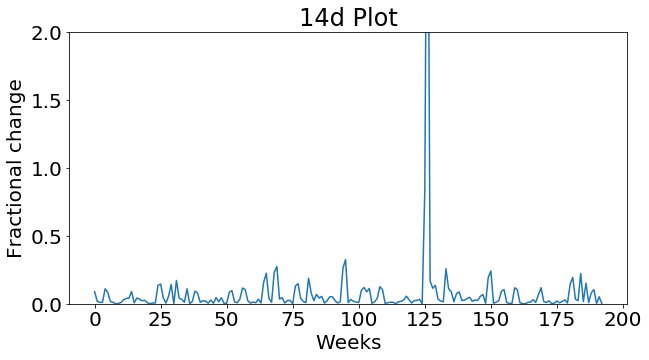

1d
stdev 47831.533042
fractional change over time 0.0871115801729


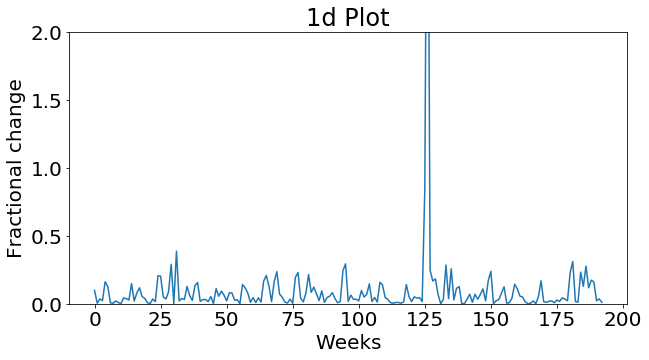

2t
stdev 11925.2628407
fractional change over time 0.0782728203517


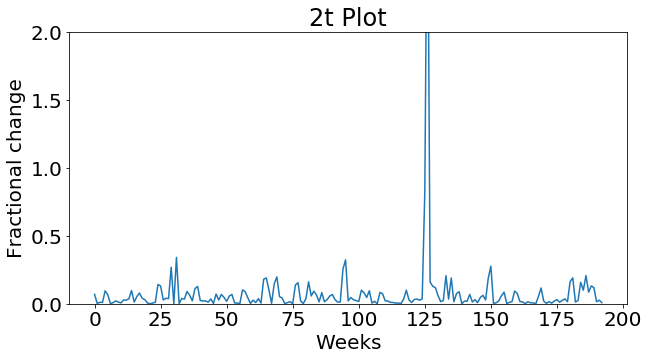

30d
stdev 13682.855002
fractional change over time 0.184673298896


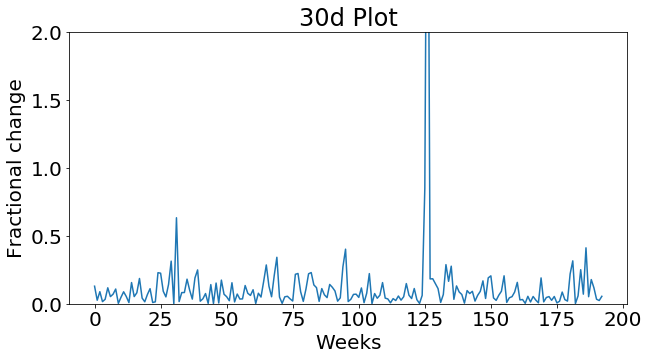

7d
stdev 384052.074685
fractional change over time 0.108928210995


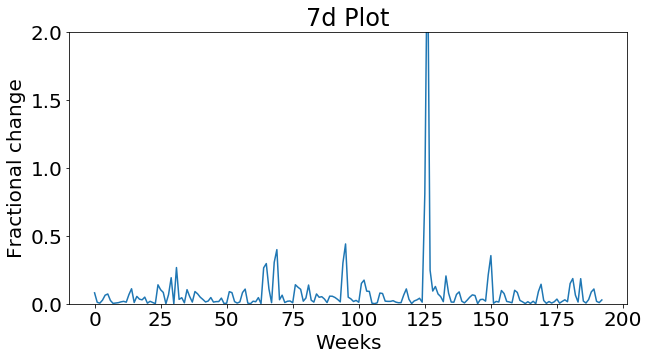

ada
stdev 758907.509912
fractional change over time 0.131846317369


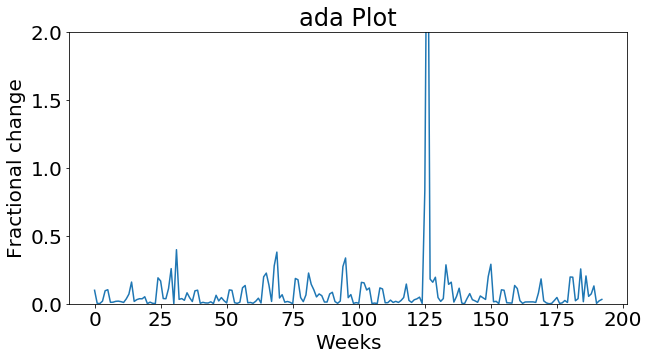

afas
stdev 526823.809932
fractional change over time 0.145386766358


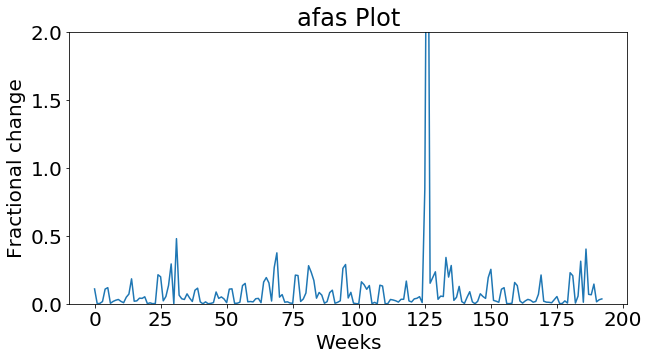

exp
stdev 57396.8374673
fractional change over time 0.483247392647


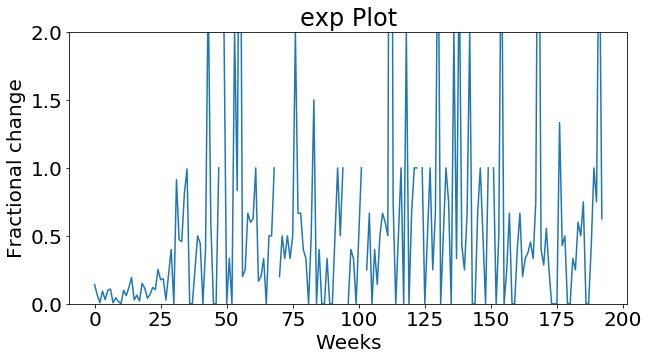

ez
stdev 165419.334684
fractional change over time 0.218396197953


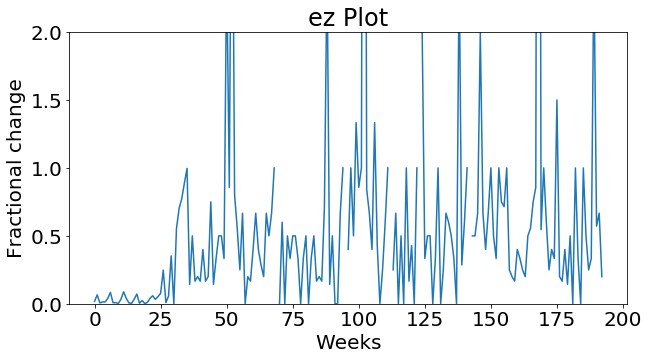

ff
stdev 115183.593085
fractional change over time 0.247107905308


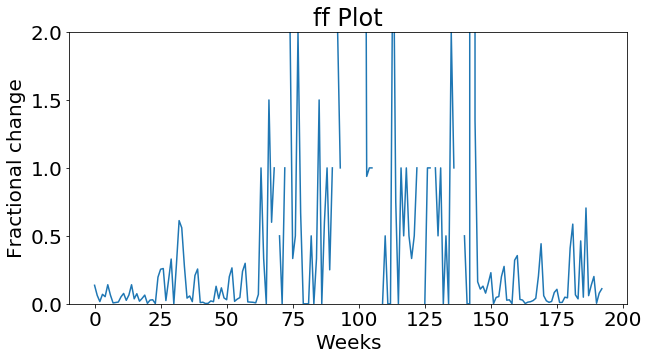

mc
stdev 23202.4464449
fractional change over time 0.308191997296


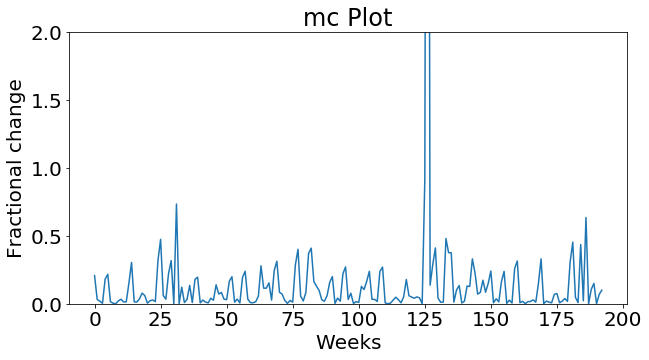

mr
stdev 43584.576565
fractional change over time 0.239405658929


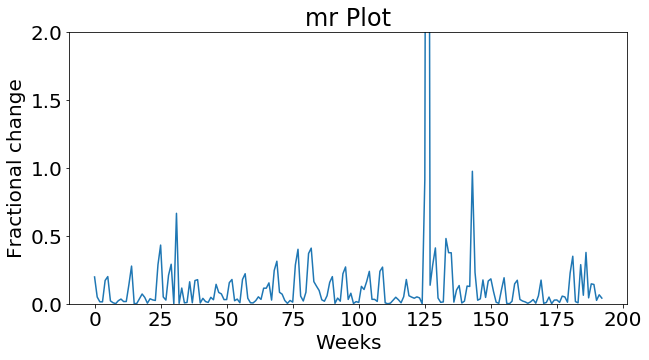

month
stdev 28178.6092263
fractional change over time 0.255768639291


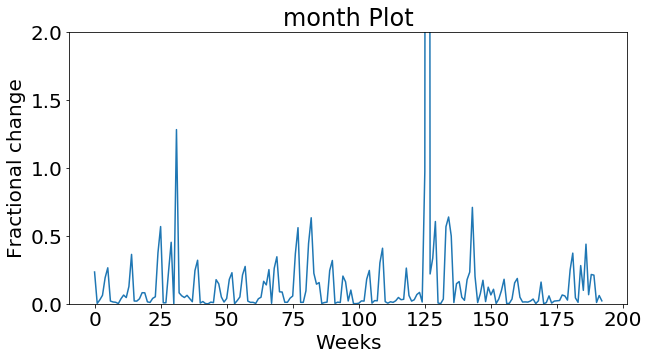

rfm
stdev 92341.6998436
fractional change over time 0.230942519474


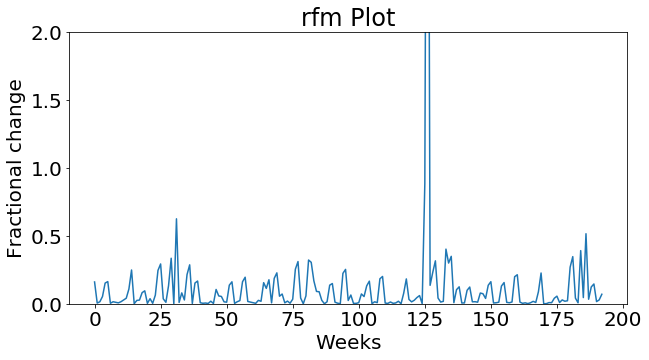

rr
stdev 82637.4966319
fractional change over time 0.211745382582


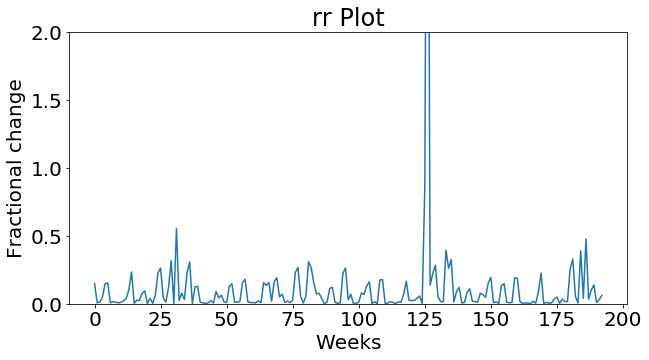

sen
stdev 29426.7721168
fractional change over time 0.199924827832


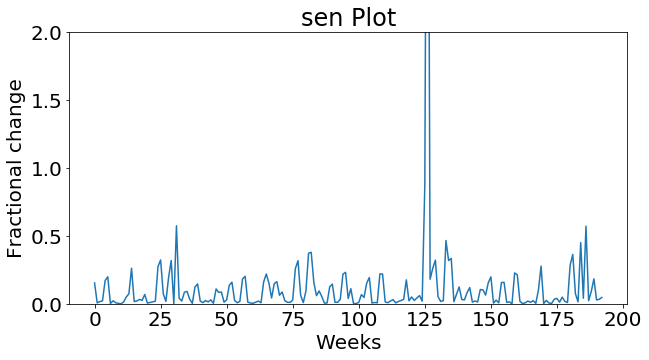

spec
stdev 15016.4833716
fractional change over time 0.164606225345


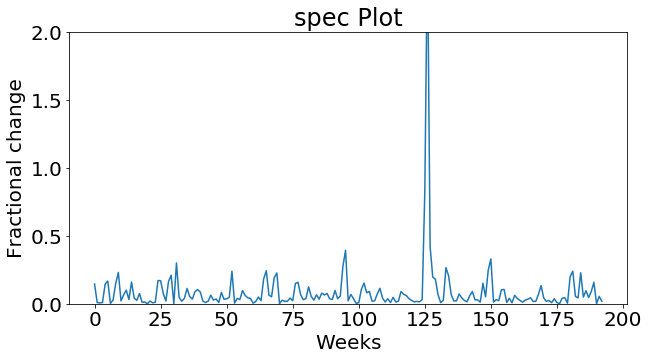

tcmc
stdev 22141.1404577
fractional change over time -0.123297016693


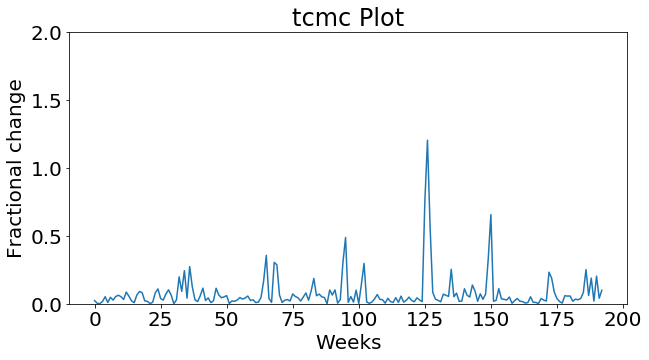

t
stdev 18059.7987674
fractional change over time -0.110572097087


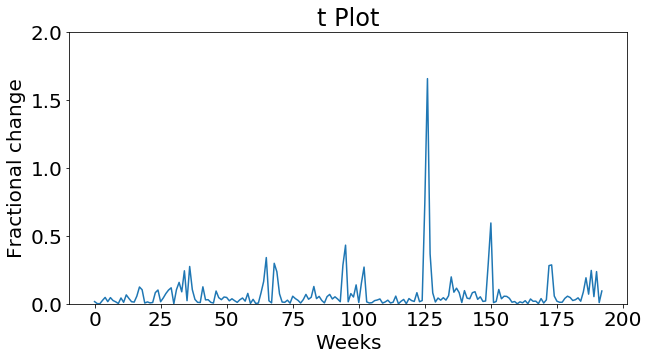

umlim
stdev 1826.44930548
fractional change over time -0.0170509620493


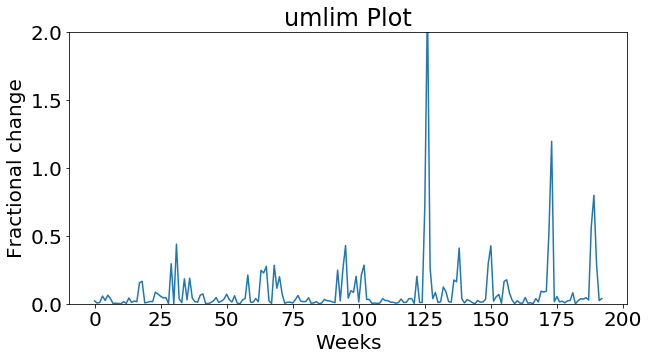

xbus
stdev 574.518216904
fractional change over time -0.0495688759851


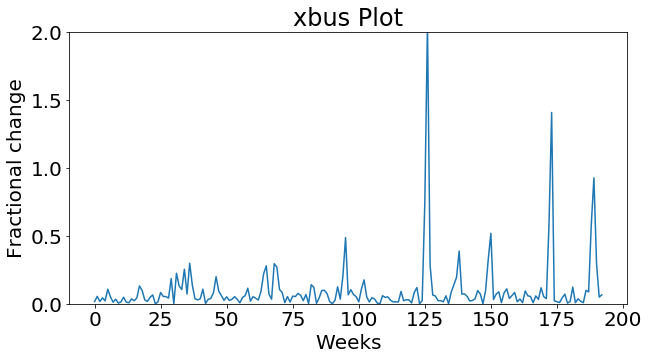

stud
stdev 333841.832718
fractional change over time 0.935793862794


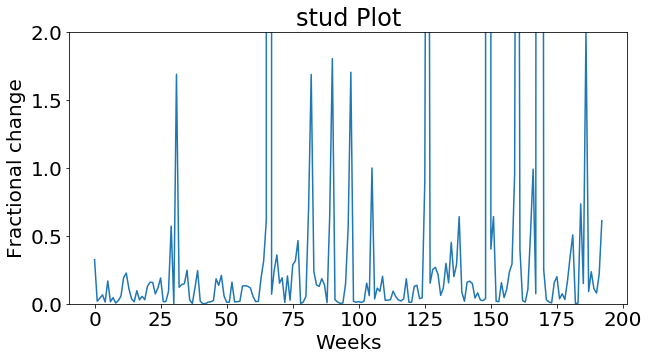

In [172]:
for i in range(1,23):
    change(i)

Figures 3 - 25: Plots between weeks and the fractional change of its quantity for each week. The fractional change over time compares the first and last values of the plot in fractional change of quantity. the three greatest fraction change over time from greatest to smallest is the stud plot, the exp plot, and the mc plot. However the graphs fail to show trends that can be easily observed and compared with each other, so perhaps measuring it by swipes instead of fractional change may be better.

14d
stdev 639273.177913
Change over time for 14d 0.915193900138


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


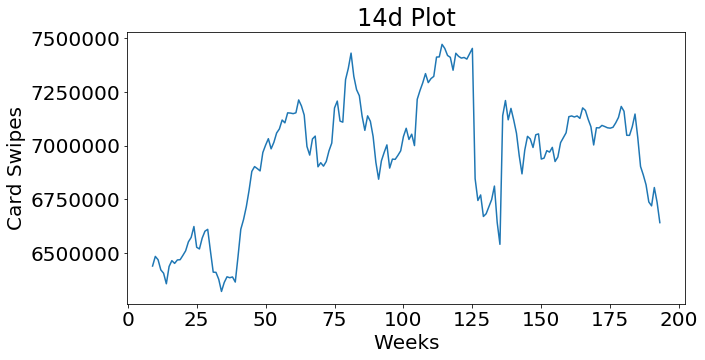

1d
stdev 47831.533042
Change over time for 1d 0.787169809266


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


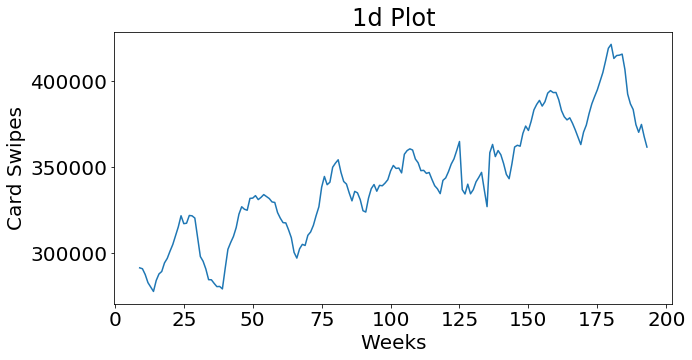

2t
stdev 11925.2628407
Change over time for 2t 0.999134531347


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


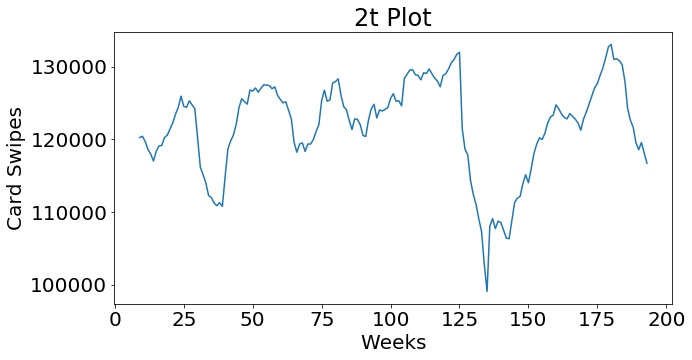

30d
stdev 13682.855002
Change over time for 30d 1.03154865575


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


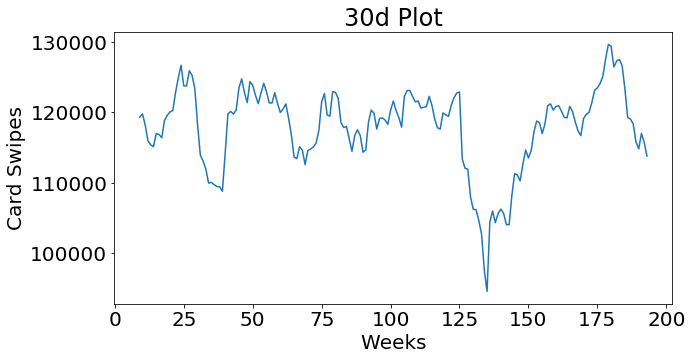

7d
stdev 384052.074685
Change over time for 7d 0.686774569621


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


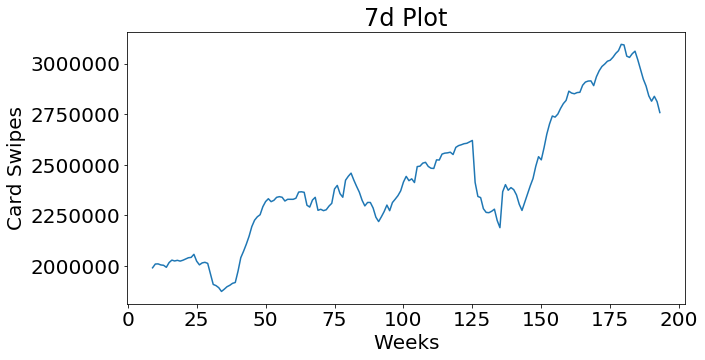

ada
stdev 758907.509912
Change over time for ada 0.86812069005


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


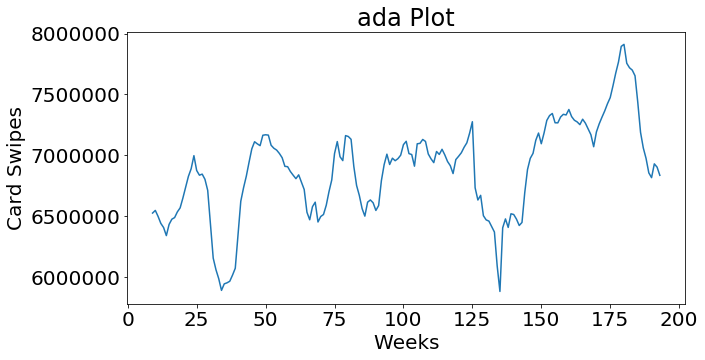

afas
stdev 526823.809932
Change over time for afas 0.983555711274


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


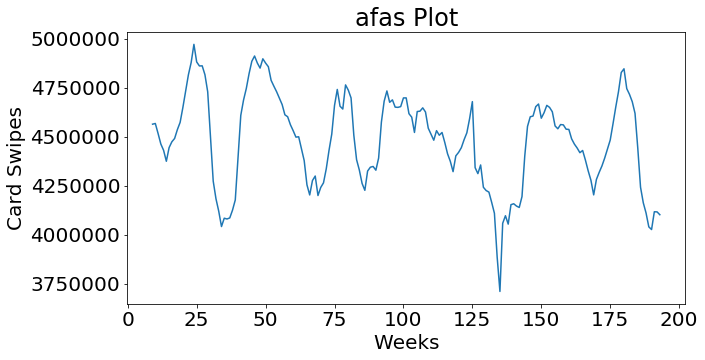

exp
stdev 57396.8374673
Change over time for exp 114420.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


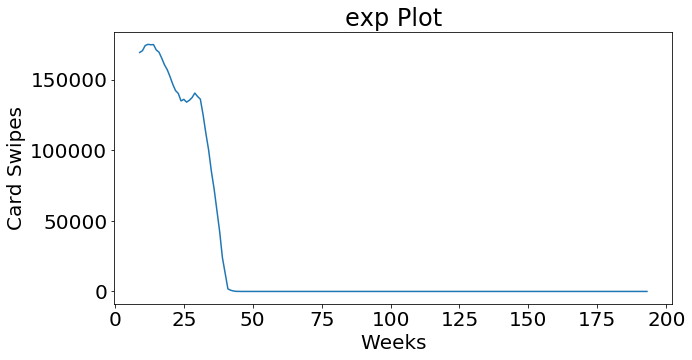

ez
stdev 165419.334684
Change over time for ez 211307.25


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


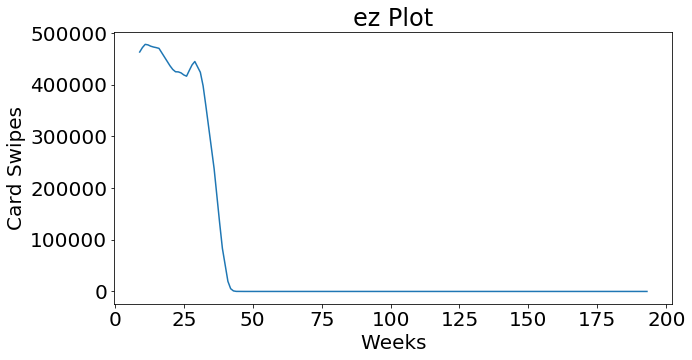

ff
stdev 115183.593085
Change over time for ff 17.0487569619


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


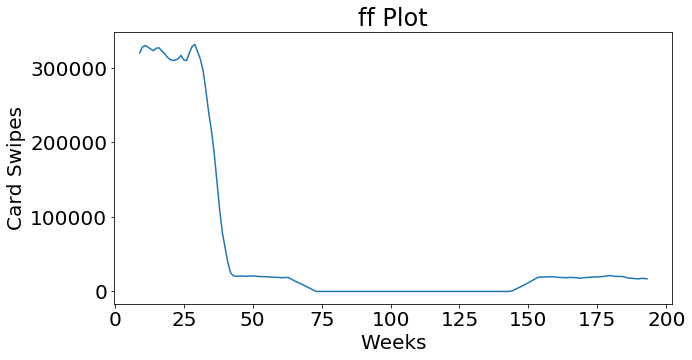

mc
stdev 23202.4464449
Change over time for mc 0.844330623306


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


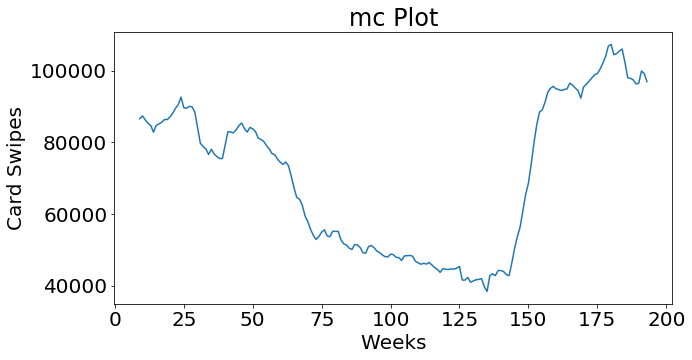

mr
stdev 43584.576565
Change over time for mr 0.40133572134


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


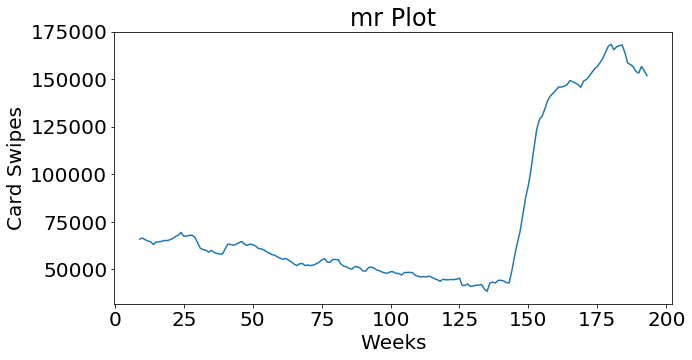

month
stdev 28178.6092263
Change over time for month 0.558132577904


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


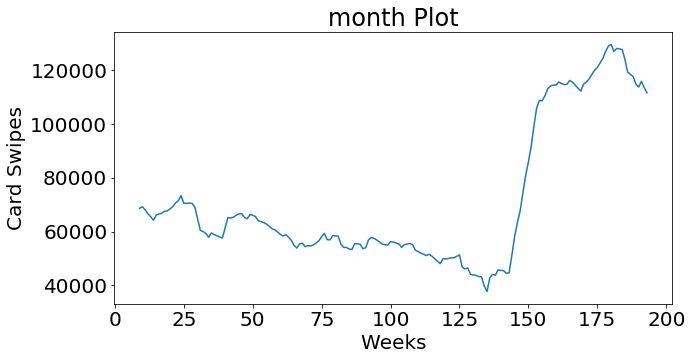

rfm
stdev 92341.6998436
Change over time for rfm 1.45820865494


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


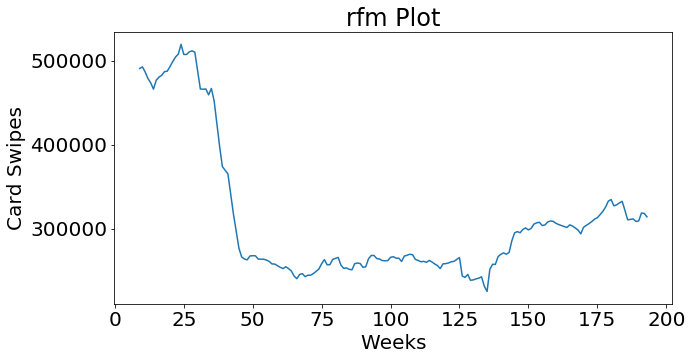

rr
stdev 82637.4966319
Change over time for rr 1.1757726254


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


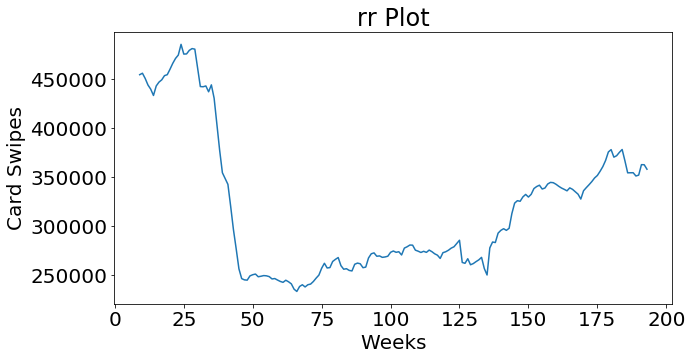

sen
stdev 29426.7721168
Change over time for sen 0.328787895765


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


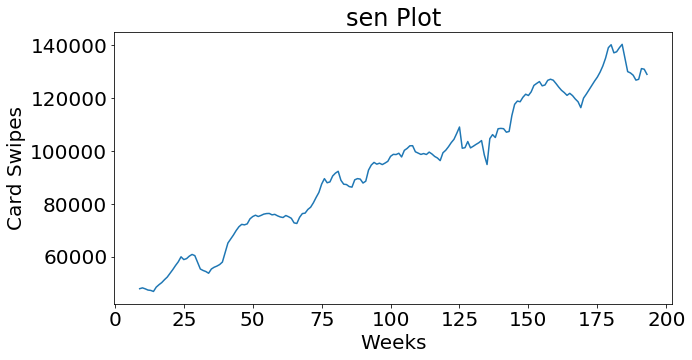

spec
stdev 15016.4833716
Change over time for spec 0.228702713216


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


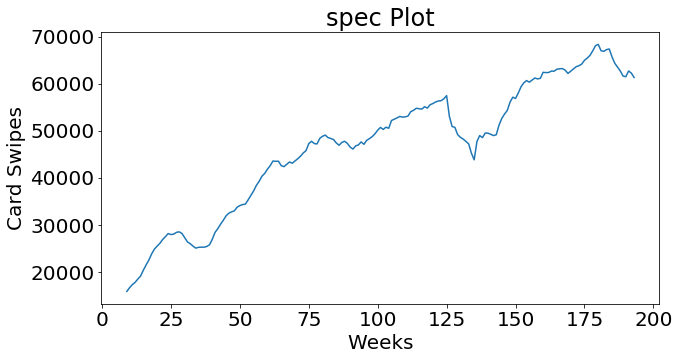

tcmc
stdev 22141.1404577
Change over time for tcmc 0.585767906385


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


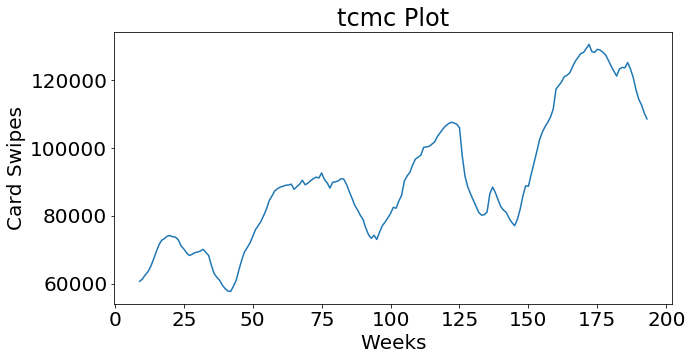

t
stdev 18059.7987674
Change over time for t 0.691332786287


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


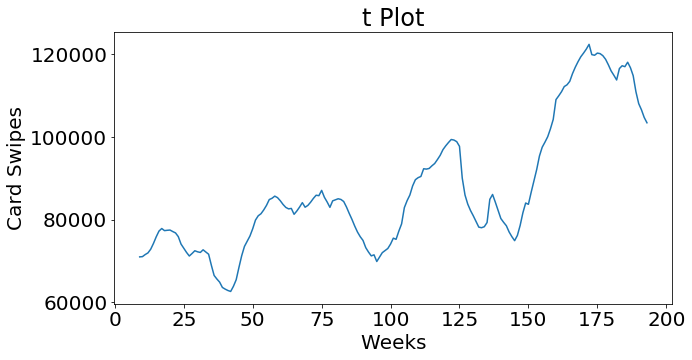

umlim
stdev 1826.44930548
Change over time for umlim 0.887018368079


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


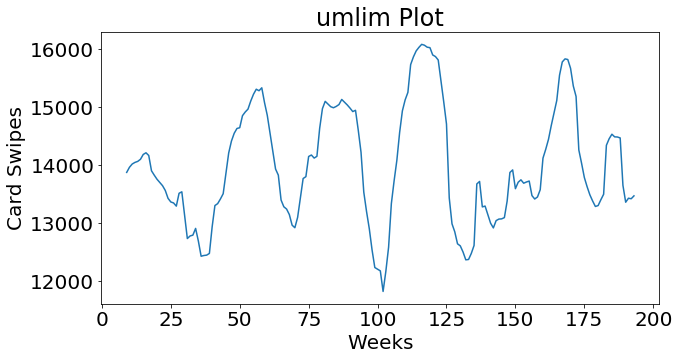

xbus
stdev 574.518216904
Change over time for xbus 0.926042261565


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


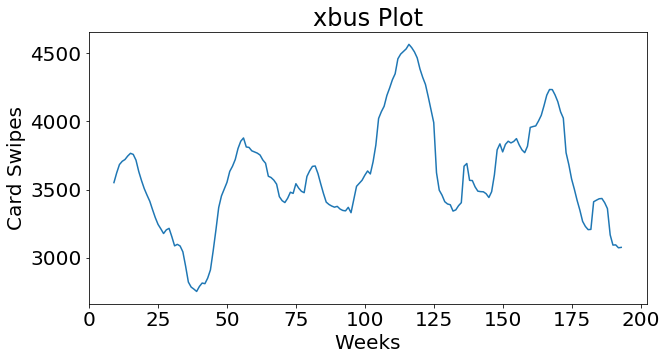

stud
stdev 333841.832718
Change over time for stud 0.000668112377248


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


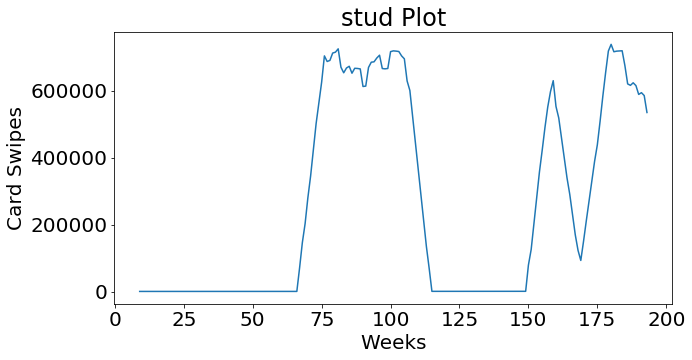

In [14]:
for i in range(1,23):
    
    print(str(ridetype[i]))
    print('stdev ' + str(np.nanstd(MTAc[::][i])))
    
    print('Change over time for ' + str(ridetype[i]) + ' ' + str((MTAc[i][0]/MTAc[i][-1])))
    
    pl.figure(figsize=(10,5))
    pl.plot((pd.rolling_mean(MTAc[i], 10)))
    pl.xlabel('Weeks')
    pl.ylabel('Card Swipes')
    pl.title(str(ridetype[i]) + " Plot")
    pl.show()

Figures 26-48: Plots for each ridetype between weeks and card swipes instead of fractional change. Change over time compares the swipes from the start and swipes from the end. The greatest changes are ez, exp, and ff, while the others are within or around 1. For those within 1, eyeballing the plots, the month plot has the greatest increase, from around 40000 to 130000, despite having a change over time of 0.558132577904. Meanwhile, eyeballing the plots, the rr plot has the steepest decrease, from 500000 swipes down to 250000, despite its change in 1.175.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [12]:
label = [np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])]
label = np.concatenate(np.repeat(label,600,axis=0))
label = label[MTA.reshape(600*23, 194).std(1) > 0]
label.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(7660,)

In [13]:
label

array([ 0,  1,  2, ..., 16, 17, 18])

In [14]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [15]:
stationsmeans = np.nanmean(np.nansum(MTA, axis=1), axis=1)
stationsmeans.shape

(600,)

In [16]:
stationsstd = np.nanstd(np.nansum(MTA, axis=1), axis=1)
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [17]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid = stationid[MTA.reshape(600*23, 194).std(1) > 0]
stationid

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([  2,   2,   2, ..., 550, 550, 550])

In [18]:
stationid.shape

(7660,)

In [19]:
stationid[7659]

550

In [20]:
MTA[stationid[7659]][label[7659]]

array([ 202.,  150.,  135.,  173.,  228.,  203.,  175.,  188.,  170.,
        214.,  177.,  183.,  195.,  194.,  186.,  170.,  239.,  169.,
        189.,  160.,  190.,  176.,  174.,  193.,  149.,  169.,  165.,
        154.,  175.,  211.,  163.,  163.,  187.,  196.,  174.,  139.,
        140.,  161.,  135.,  127.,  132.,  127.,  175.,  166.,  166.,
        180.,  156.,  199.,  145.,  142.,  200.,  195.,  173.,  176.,
        203.,  242.,  176.,  219.,  161.,  172.,  150.,  165.,  161.,
        197.,  197.,  142.,  197.,  194.,  187.,  136.,  235.,  200.,
        211.,  174.,  167.,  201.,  138.,  137.,  123.,  160.,  135.,
        183.,  186.,  228.,  159.,  135.,  156.,  142.,  171.,  169.,
        160.,  166.,  155.,  148.,  115.,  116.,  148.,  156.,  145.,
        157.,  190.,  176.,  161.,  162.,  198.,  175.,  187.,  171.,
        179.,  178.,  160.,  166.,  163.,  169.,  154.,  156.,  220.,
        223.,  229.,  217.,  212.,  180.,  213.,  188.,  190.,  191.,
         64.,   75.,

In [21]:
#tots = MTA.reshape(600*23, 194)
#tots = tots[~np.isnan(tots).any(1)]

#tots = np.concatenate([np.array(MTA[stationid[i]][label[i]]) for i in range(7660)], axis=0)
#tots = tots[MTA.reshape(600*23, 194).std(1) > 0]

#tots= np.empty((7660,194),dtype=float)

#tots = np.array(MTA[stationid][label])

#arr = []
#arr.append(np.array([1,2,3]))
#arr.append(np.array([4,5,6]))
#np_arr = np.array(arr)

tots = []

for i in range(0,7660):
    #for j in range(0,7660):
    tots.append(np.array(MTA[stationid[i]][label[i]]))
    
tots = np.array(tots)

In [22]:
tots.shape

(7660, 194)

In [23]:
tots

array([[ 3292.,  3429.,  3629., ...,  3746.,  3406.,  3217.],
       [  110.,    92.,   102., ...,   212.,   209.,   211.],
       [    7.,     6.,    13., ...,    26.,    20.,    22.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,  1959.,  1773.,  1667.],
       [  202.,   150.,   135., ...,   213.,   168.,   214.]])

In [24]:
#(time_series - time_series.mean())/time_series.std()

#normed_time_series_mean = np.empty((7660, 194))
#normed_time_series_std = np.empty((7660, 194))

#the time series mean divided by the mean of all time series for that station
#the time series standard deviation by the standard deviation of all time series for that station
#the slope and intercept of a line fit to the standardized time series

#axis=0 is stationid

#standardizedts = np.empty((7660,194),dtype=float)

standardizedts = []

for i in range(0,7660):
    standardizedts.append(np.array(tots[i] - tots[i].mean())/tots[i].std())

normed_time_series_mean = np.array(standardizedts).mean(axis=0)
normed_time_series_std = np.array(standardizedts).std(axis=0)

In [25]:
normed_time_series_std[:10]

array([ 1.33763603,  1.32408461,  1.3553746 ,  1.36692992,  1.31939013,
        1.35964023,  1.34236044,  1.35802962,  1.37300832,  1.34829259])

In [26]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape


(7660,)

In [27]:
tsmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [28]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(7660,)

In [29]:
tsstdev[:10]


array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

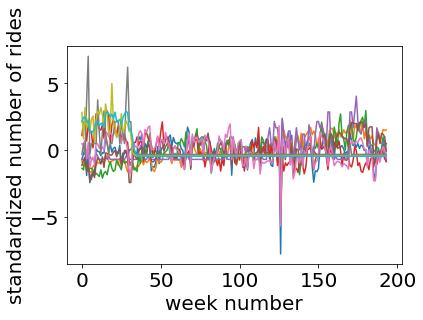

In [30]:
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [31]:
standardizedts = np.array(standardizedts)

In [32]:
date = pd.date_range("2010-05-21","2014-03-21",194)

Y = standardizedts[1]
X = range(len(date))
X = sm.add_constant(X)

model = sm.OLS(Y,X)
result = model.fit()
result.params

array([-1.45472894,  0.01507491])

In [33]:
result.tvalues

array([-18.87680042,  21.82526787])

In [34]:
allfits = []
for i in range(0,7660):
    thisfit = sm.OLS(standardizedts[i], X)
    thisfit = thisfit.fit()
    allfits.append(thisfit.params)

[a[1] for a in allfits[:10]]

[9.7580952041542224e-05,
 0.01507491129603278,
 0.011078420496296554,
 -0.011058851565539807,
 0.010604996938815645,
 0.0090297300544243293,
 -0.005927016014076753,
 -0.0077398609043442222,
 -0.01082536649473384,
 -0.011436050107515458]

In [35]:
ts = standardizedts
normedtsmean = np.array(standardizedts).mean(axis=1)
normedtsstd = np.array(standardizedts).std(axis=1)

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a[0] for a in allfits], [a[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [38]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(422, 254, 0, 0)

In [39]:
X_train[~np.isfinite(X_train)] = 0
X_test[~np.isfinite(X_test)] = 0

In [40]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

and use sklearn confusion_matrix to see the errors

In [41]:
clf =  ensemble.RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


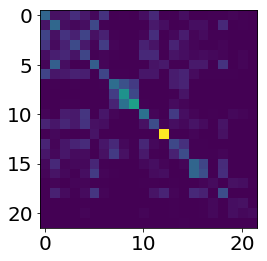

In [42]:
imshow(confusion_matrix(y_test, y_pred))

In [43]:
len(label)

7660

In [44]:
len(ridetype)

23

In [45]:
ridetype = np.array(['14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [46]:
print(classification_report(y_test, y_pred, target_names=ridetype))

              precision    recall  f1-score   support

         14d       0.25      0.31      0.28       135
          1d       0.25      0.32      0.28       133
          2t       0.16      0.13      0.14       148
         30d       0.23      0.20      0.21       147
          7d       0.16      0.22      0.19       124
         ada       0.26      0.26      0.26       144
        afas       0.23      0.19      0.21       142
         exp       0.36      0.37      0.36       126
          ez       0.42      0.53      0.47       125
          ff       0.58      0.51      0.54       143
          mc       0.38      0.35      0.37       137
          mr       0.23      0.22      0.22       138
       month       0.77      0.87      0.82       149
         rfm       0.23      0.19      0.21       146
          rr       0.25      0.25      0.25       119
         sen       0.31      0.30      0.31       138
        spec       0.30      0.22      0.25       142
        tcmc       0.21    

Figures 49 and 50: Confusion Matrix and Classification Report of normalized mean and std ticket type based on 4 engineered features. The important feature here is the average, which is 0.3.

## Build a model that uses as input features each time stamp (194 features) :


In [49]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a[0] for a in allfits], [a[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

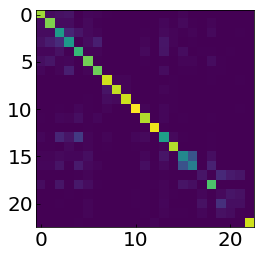

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   